In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os

sys.path.append('../')

from functions import *
from functions.preprocessing import *
from functions.swing_points import *
from functions.fvg import *

quandl_api_key = '_umNYuQHdkCgs9Rcm4Fv'

In [4]:
df_es = pd.read_csv('../data/es-1m_bk.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'vol'])
df_es['datetime'] = pd.to_datetime(df_es.date + ' ' + df_es.time, format='%d/%m/%Y %H:%M')
df_es = df_es.infer_objects()
df_es.set_index(df_es.datetime, inplace=True)
df_es.index = df_es.index.tz_localize('America/Chicago').tz_convert('America/New_York')
df_es.drop(columns=['date', 'time', 'datetime', 'vol'], inplace=True)
df_es = df_es[~df_es.index.duplicated(keep='last')]

df_nq = pd.read_csv('../data/nq-1m_bk.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'vol'])
df_nq['datetime'] = pd.to_datetime(df_nq.date + ' ' + df_nq.time, format='%d/%m/%Y %H:%M')
df_nq = df_nq.infer_objects()
df_nq.set_index(df_nq.datetime, inplace=True)
df_nq.index = df_nq.index.tz_localize('America/Chicago').tz_convert('America/New_York')
df_nq.drop(columns=['date', 'time', 'datetime', 'vol'], inplace=True)
df_nq = df_nq[~df_nq.index.duplicated(keep='last')]

df_ym = pd.read_csv('../data/ym-1m_bk.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'vol'])
df_ym['datetime'] = pd.to_datetime(df_ym.date + ' ' + df_ym.time, format='%d/%m/%Y %H:%M')
df_ym = df_ym.infer_objects()
df_ym.set_index(df_ym.datetime, inplace=True)
df_ym.index = df_ym.index.tz_localize('America/Chicago').tz_convert('America/New_York')
df_ym.drop(columns=['date', 'time', 'datetime', 'vol'], inplace=True)
df_ym = df_ym[~df_ym.index.duplicated(keep='last')]

df_dx = pd.read_csv('../data/dlarind-1m_bk.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'vol'])
df_dx['datetime'] = pd.to_datetime(df_dx.date + ' ' + df_dx.time, format='%d/%m/%Y %H:%M')
df_dx = df_dx.infer_objects()
df_dx.set_index(df_dx.datetime, inplace=True)
df_dx.index = df_dx.index.tz_localize('America/Chicago').tz_convert('America/New_York')
df_dx.drop(columns=['date', 'time', 'datetime', 'vol'], inplace=True)
df_dx = df_dx[~df_dx.index.duplicated(keep='last')]

In [ ]:
# df_es.to_parquet('df_es.parquet', index=True)
# df_nq.to_parquet('df_nq.parquet', index=True)
# df_dx.to_parquet('df_dx.parquet', index=True)
# df_ym.to_parquet('df_ym.parquet', index=True)

In [ ]:
# test = False
# if test:
#     df_es = pd.read_csv('EP_test_set.csv', sep='\t')
#     df_nq = pd.read_csv('ENQ_test_set.csv', sep='\t')
#     df_es = preprocess_dataframe(df_es, log_returns=False)
#     df_nq = preprocess_dataframe(df_nq, log_returns=False)
# else:    
#     df_es = pd.read_csv('/Users/kush/Desktop/futures_data/EP.csv', low_memory=True)
#     df_nq = pd.read_csv('/Users/kush/Desktop/futures_data/ENQ.csv', low_memory=True)
    
#     rows = 100000000#max(len(df_es), len(df_nq)) // 2
#     df_es = df_es[-rows:]
#     df_nq = df_nq[-rows:]
    
#     df_es = preprocess_dataframe(df_es, log_returns=False)
#     df_nq = preprocess_dataframe(df_nq, log_returns=False)


In [5]:
df_list = []
for df in [df_es, df_nq, df_dx, df_ym]:
    lookback = 20
    timeframes = ['1T', '5T', '15T', '1H', '4H', '1B']
    timeframes_fvg = ['1T', '5T', '15T', '1H', '4H', '1B']
    df = identify_swing_points_optimized(df, timeframes, get_swing_values=False, interpolation_method='None')
    df = identify_fair_value_gaps_optimized(df, timeframes_fvg, get_high_low=False)
    df_list.append(df)

In [8]:
df = pd.merge(df_list[0], df_list[1], 'inner', 'datetime', suffixes=('_es', '_nq'))
del(df_es)
del(df_nq)

df_list[2].columns = [c + '_dx' for c in df_list[2].columns]
df = pd.merge(df, df_list[2], 'inner', 'datetime')
del(df_dx)

df_list[3].columns = [c + '_ym' for c in df_list[3].columns]
df = pd.merge(df, df_list[3], 'inner', 'datetime')
del(df_ym)

del(df_list)

In [9]:
df = df.assign(
    month=df.index.month,
    day=df.index.day,
    hour=df.index.hour,
    minute=df.index.minute,
    day_of_week=df.index.dayofweek.astype('int8')
)

In [10]:
def add_cyclic_date_features(df, column, max_val):
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val).astype('float32')
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val).astype('float32')
    df.drop(columns=column, inplace=True)

add_cyclic_date_features(df, 'month', 12)
add_cyclic_date_features(df, 'day', 31)
add_cyclic_date_features(df, 'hour', 23)
add_cyclic_date_features(df, 'minute', 60)
add_cyclic_date_features(df, 'day_of_week', 6)

In [11]:
# Get weekly open and closes and midnight open
df['weekly_open'] = df.open_es.resample('W-SAT', label='left').first().reindex(df.index, method='ffill')
df['weekly_close'] = df.close_es.resample('W-SAT', label='left').first().shift(1).reindex(df.index, method='ffill')
df['daily_open'] = df.open_es.resample('D', label='left').first().reindex(df.index, method='ffill')

In [12]:
price_cols = df.columns[(df>1).any()]
cyclical_cols = [c for c in df.columns if re.match(r'^.*(_sin|_cos)', c)]
swing_cols = [c for c in df.columns if 'swing' in c]
fvg_cols = [c for c in df.columns if 'fair' in c]


## Get News Data

In [41]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from dateutil.rrule import rrule, WEEKLY
import datetime as dt
import requests

In [42]:
# Define start and end dates
start_date = dt.datetime(2008, 1, 1)
end_date = dt.datetime.now()

dates = [dt for dt in rrule(WEEKLY, dtstart=start_date, until=end_date)]

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame(columns=['Date', 'Time', 'Currency', 'Event', 'Impact'])

for d in dates:
    url = 'https://www.forexfactory.com/calendar?week={}'.format(d.strftime('%b%d.%Y').lower())
    
    # Make a request to the website
    req = Request(url , headers={'User-Agent': 'Mozilla/5.0'})

    page = urlopen(req).read()
    soup = BeautifulSoup(page, 'html.parser')
    
    data = []
    for row in soup.find_all('tr', {'class': 'calendar_row'}):
        event = row.find('td', {'class': 'calendar__event'}).text.strip()
        if event:
            date = (row.find('td', {'class': 'calendar__date'}).text.strip() + ' ' + str(d.year)) if row.find('td', {'class': 'calendar__date'}).text.strip() else np.nan
            time = row.find('td', {'class': 'calendar__time'}).text.strip()
            currency = row.find('td', {'class': 'calendar__currency'}).text.strip()

            impact = row.find('td', {'class': 'calendar__impact'}).find('span').get('title').split(' ')[0]

            data.append([date, time, currency, event, impact])
            
    temp_df = pd.DataFrame(data, columns=['Date', 'Time', 'Currency', 'Event', 'Impact'])
    all_data = pd.concat([all_data, temp_df], ignore_index=True)

all_data['Date'] = all_data.Date.ffill()
all_data['Date'] = all_data['Date'].apply(lambda x: dt.datetime.strptime(x, '%a%b %d %Y'))
all_data['Time'] = all_data['Time'].apply(lambda x : x[:-2])
all_data['Time'] = all_data.Time.replace('', np.nan).replace('All D', '00:00')
all_data['Time'] = all_data.Time.ffill()

med_high = all_data.query('(Impact == "High" or Impact == "Medium") and Currency == "USD"')
med_high[med_high.Time.str.contains('Feb')]
med_high = med_high.drop(index=[51079, 51080])

med_high['Time'] = pd.to_timedelta(med_high['Time'] + ':00')  # Add ':00' to convert the time string to 'HH:MM:SS' format
med_high['datetime'] = med_high['Date'] + med_high['Time']
med_high = med_high.set_index('datetime').drop(columns=['Date', 'Time', 'Currency'])
med_high.index = med_high.index.tz_localize('America/New_York')

new_data = med_high.pivot_table(index='datetime', columns='Event', values='Impact', fill_value=0, aggfunc='first').replace({"Medium": 1, "High": 1}).join(
pd.get_dummies(med_high.Impact).groupby('datetime').agg(max)
)
new_data.to_csv('news_data_2008.csv', index=True)

### Load News Data

In [12]:
med_high = pd.read_csv('news_data_2008.csv').set_index('datetime')
med_high.columns = ['news_' + c for c in med_high.columns]

In [13]:
df = df.join(med_high).fillna(0)

In [13]:
df = df.fillna(0)

In [ ]:
df.to_parquet()

## Save Data 

In [11]:
import re

# Define the resample timeframes
timeframes = ['1T', '5T', '15T', '1H', '4H', '1B']

import re

resample_cols = {
    '1T': r'((open|high|low|close)_.*)|(swing_1T_.*)|(fair_value_gap_1T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '5T': r'((open|high|low|close)_.*)|(swing_5T_.*)|(fair_value_gap_5T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '15T': r'((open|high|low|close)_.*)|(swing_15T_.*)|(fair_value_gap_15T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '1H': r'((open|high|low|close)_.*)|(swing_1H_.*)|(fair_value_gap_1H)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '4H': r'((open|high|low|close)_.*)|(swing_4H_.*)|(fair_value_gap_4H)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '1B': r'((open|high|low|close)_.*)|(swing_1B_.*)|(fair_value_gap_1B)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
}

aggs = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'swing_.*': 'first',
    'fair_value_gap_.*': lambda x: x[x!=0].iloc[0] if len(x[x!=0]) > 0 else 0,
    'minute.*': 'first',
    'hour.*': 'first',
    'day.*': 'first',
    'month.*': 'first',
    'day_of_week_.*': 'first',
    'weekly_open': 'first',
    'weekly_close': 'first',
    'daily_open': 'first',
    'news_.*' : 'max'
}

keep_cols = {}
for timeframe, regex in resample_cols.items():
    cols = []
    for col in df.columns:
        if re.match(regex, col):
            cols.append(col)
    agg_cols = {}
    for col in cols:
        for agg in aggs:
            if re.match(agg, col):
                agg_cols[col] = aggs[agg]
                break
    keep_cols[timeframe] = agg_cols


In [ ]:
from tsfracdiff import FractionalDifferentiator
from fracdiff.sklearn import FracdiffStat
import pickle

df.index = pd.to_datetime(df.index)
#df = df.astype({col: 'float32' for col in df.select_dtypes(include='float64').columns})
#df = df.astype({col: 'int8' for col in df.select_dtypes(include=['int64', 'object']).columns})

for t in timeframes:
    print(t)
    if t == '1T':
        temp = df[[c for c in df.columns if re.match(resample_cols['1T'], c)]].dropna()
    elif t == '4H':
        temp = df.resample(t, offset='2H').agg(keep_cols[t]).dropna()
    else:
        temp = df.resample(t).agg(keep_cols[t]).dropna()
        
    
    #s = FractionalDifferentiator(memoryThreshold=1e-2)
    s = FracdiffStat()
    temp.loc[:, price_cols] = s.fit_transform(temp[price_cols])  
    with open(f'FractionalDifferentiator_{t}.pkl', 'wb') as file:
        pickle.dump(s, file)
        
    temp = temp.astype({col: 'float32' for col in temp.select_dtypes(include='float64').columns})
    temp = temp.astype({col: 'int8' for col in temp.select_dtypes(include='int64').columns})
    temp.dropna().to_parquet(f'df_{t}.parquet', index=True)

1T


## Plotting Data for Review

In [19]:
from fracdiff.sklearn import FracdiffStat
from sklearn.preprocessing import MinMaxScaler
m = MinMaxScaler()
s = FracdiffStat()

In [ ]:
temp = df[[c for c in df.columns if re.match(resample_cols['1T'], c)]].dropna()
temp.loc[:, price_cols] = m.fit_transform(temp.loc[:, price_cols])

In [ ]:
temp.loc[:, price_cols[0]] = s.fit_transform(temp.loc[:, price_cols[0]].values.reshape(-1,1))

/Users/kush/Documents/DS/env/lib/python3.10/site-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


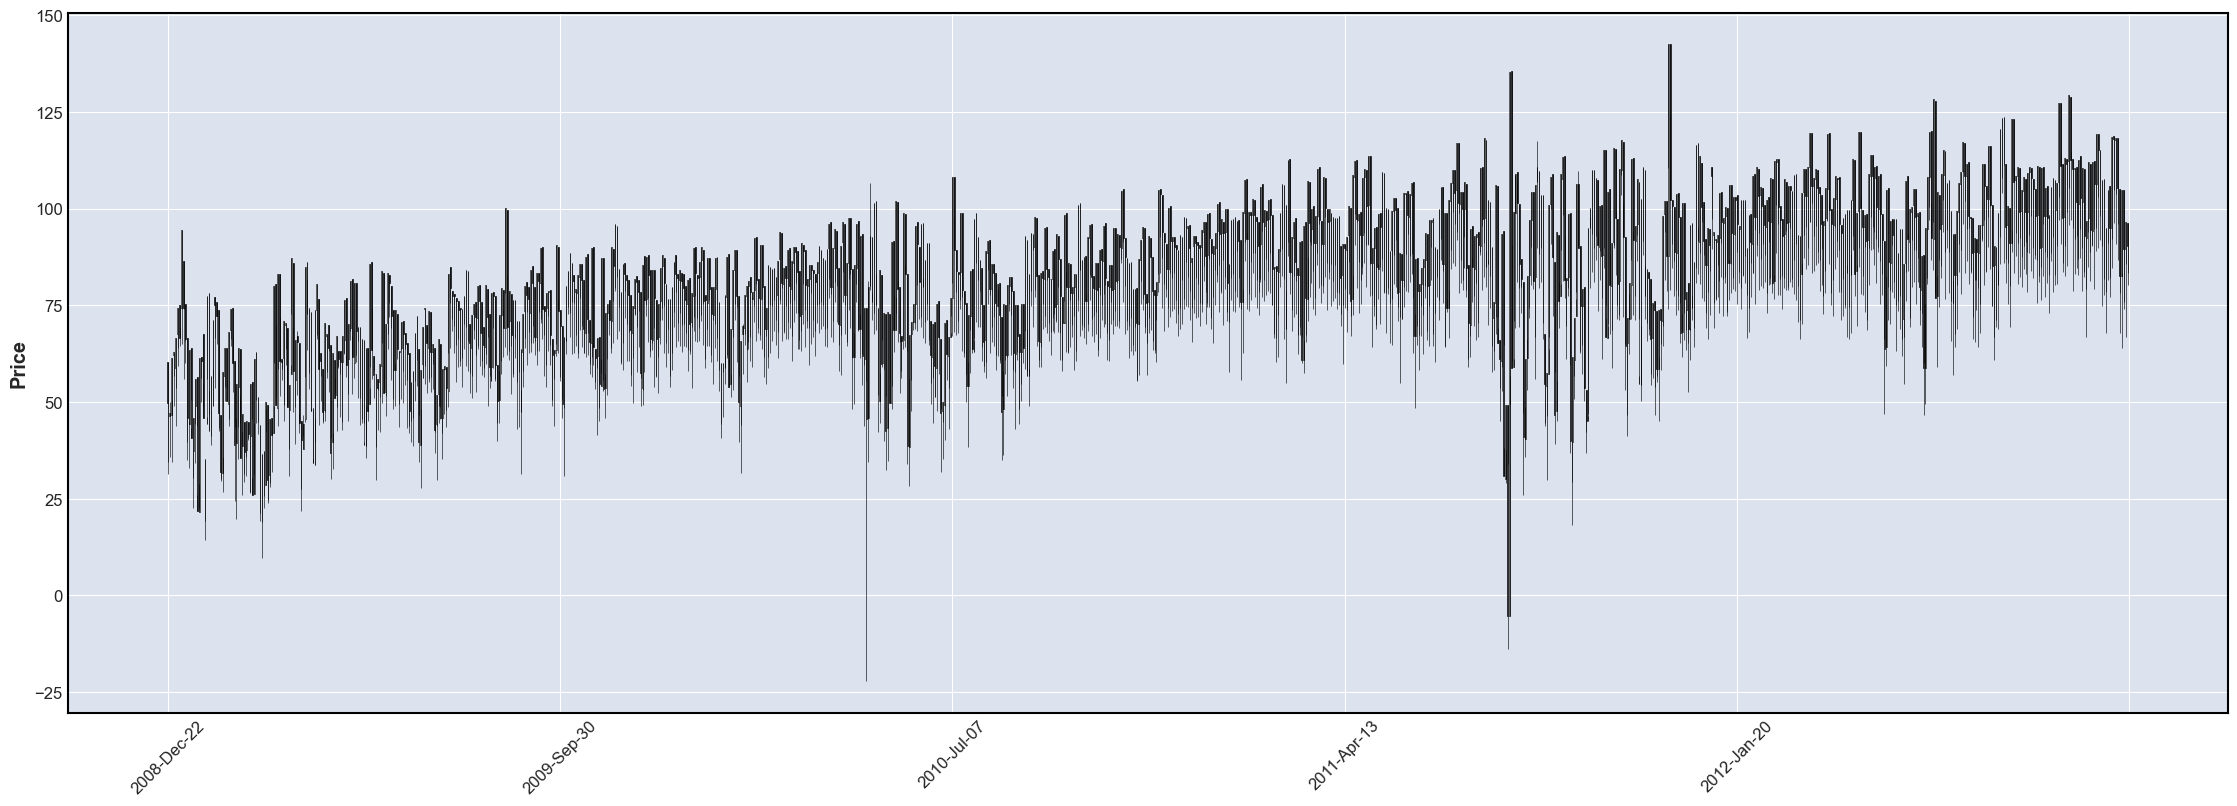

In [29]:
mpf.plot(temp.dropna()[:1000].rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).astype('float32'), type='candle', figsize=(30,10))

In [33]:
temp = pd.read_parquet('df_1T_fd.parquet').rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).astype('float32')#df.resample('1B').agg(keep_cols['1B']).dropna().convert_dtypes()

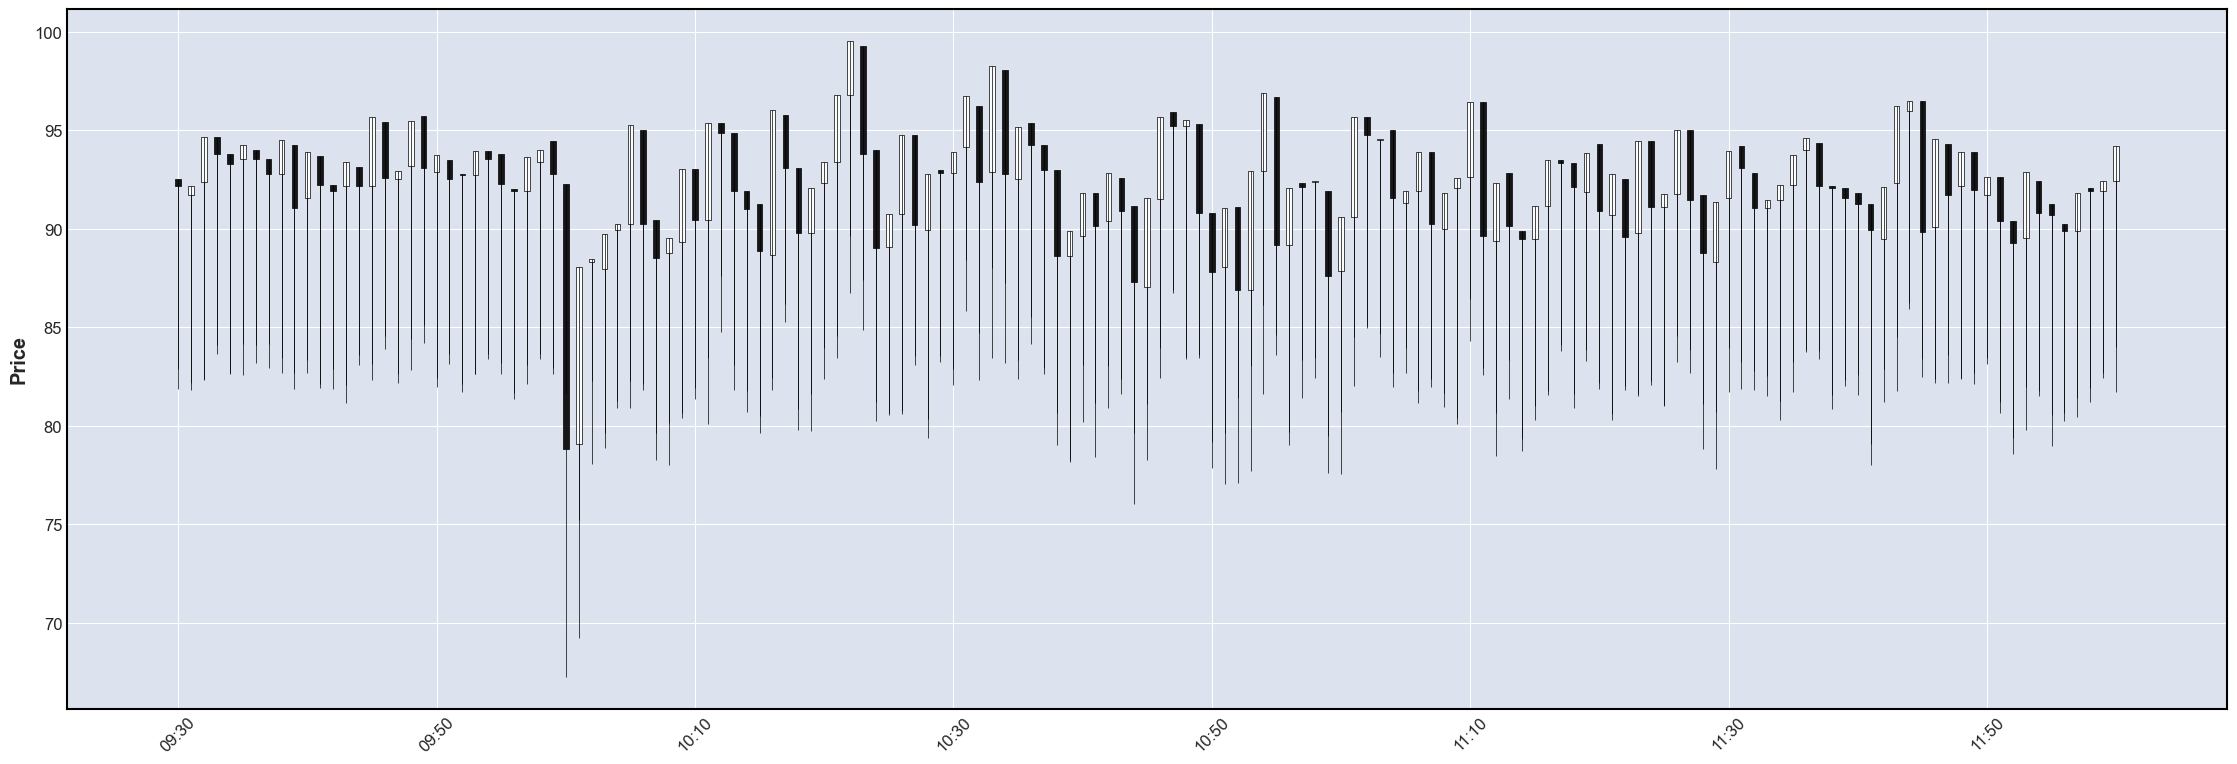

In [34]:
mpf.plot(temp.dropna().loc['2023-03-07 9:30':'2023-03-07 12:00'], type='candle', figsize=(30,10))

In [35]:
temp2 = pd.read_parquet('df_1T.parquet').rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).astype('float32')#df.resample('1B').agg(keep_cols['1B']).dropna().convert_dtypes()

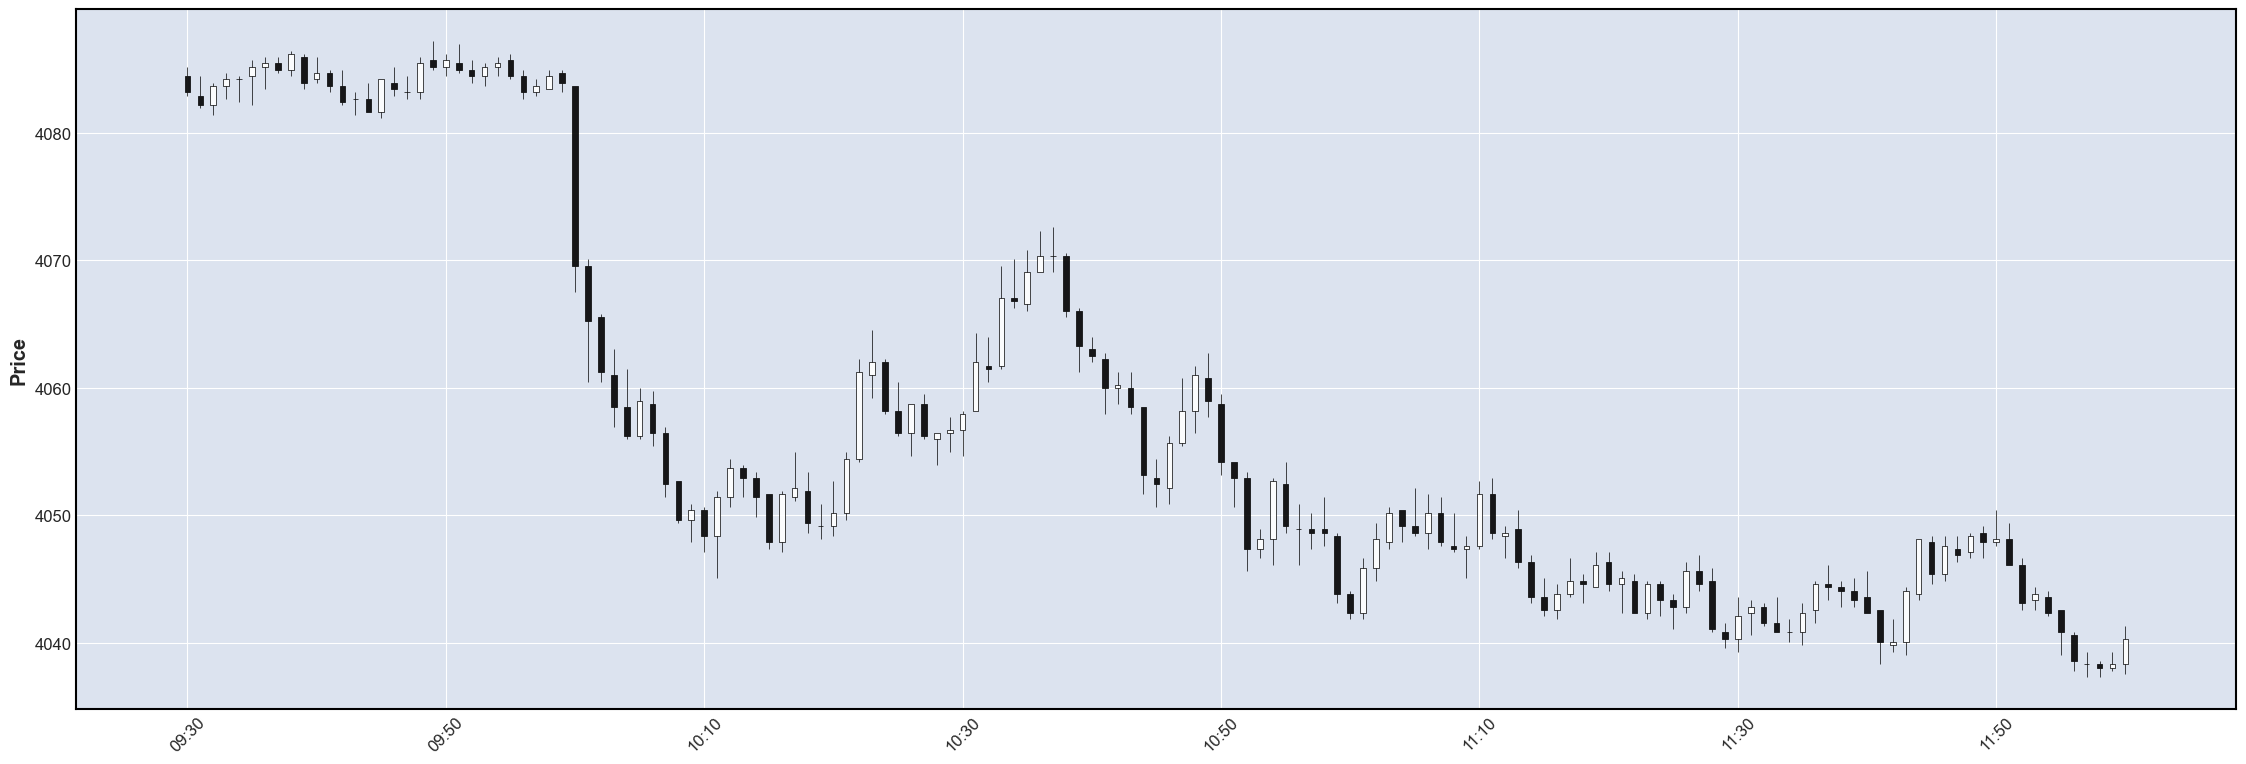

In [36]:
mpf.plot(temp2.dropna().loc['2023-03-07 9:30':'2023-03-07 12:00'], type='candle', figsize=(30,10))

In [37]:
temp

,open,high,low,close,swing_1T_es,fair_value_gap_1T_es,open_nq,high_nq,low_nq,close_nq,...,news_Treasury Currency Report,news_Treasury Sec Geithner Speaks,news_Treasury Sec Lew Speaks,news_Treasury Sec Mnuchin Speaks,news_Treasury Sec Paulson Speaks,news_Treasury Sec Yellen Speaks,news_Unemployment Claims,news_Unemployment Rate,news_High,news_Medium
datetime,,,,,,,,,,,,,,,,,,,,,
2008-12-11 03:49:00-05:00,18.258686,16.715897,16.260632,18.932573,1.0,0.0,36.040112,32.099506,31.623760,35.549526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-11 03:50:00-05:00,18.514252,16.076916,16.273535,17.433155,0.0,0.0,35.569363,31.630354,32.105339,36.034134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-11 03:51:00-05:00,17.420082,15.395041,15.162540,17.367493,0.0,0.0,35.283237,31.350344,31.113075,35.301521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-11 03:54:00-05:00,18.032177,16.707521,16.908327,19.343948,0.0,0.0,36.772602,32.843155,33.085087,36.779175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-11 03:55:00-05:00,18.493364,15.853811,15.398207,17.669333,0.0,1.0,35.604195,32.172520,31.673096,36.111916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-17 00:50:00-04:00,94.294739,83.835678,83.590370,94.052063,0.0,0.0,393.294342,349.960480,349.420502,392.760223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-17 00:53:00-04:00,94.052063,83.590370,83.830605,94.289032,-1.0,0.0,394.241394,350.918152,351.604126,394.927216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-17 00:54:00-04:00,94.289032,83.830605,83.835297,94.296356,0.0,0.0,394.030640,351.206665,350.964630,395.046295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
